# MobileNetV3 Model Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [2]:
# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size
batch_size = 32

train_generator = train_datagen.flow_from_directory('split_data/train', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('split_data/val', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('split_data/test', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

def create_mobilenetv3_model():
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Initialize and compile the model
mobilenetv3_model = create_mobilenetv3_model()
mobilenetv3_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_mobilenetv3 = mobilenetv3_model.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the model
mobilenetv3_model.save('mobilenetv3_model.h5')


Found 8449 images belonging to 6 classes.
Found 2802 images belonging to 6 classes.
Found 1450 images belonging to 6 classes.
Epoch 1/50
265/265 [==============================] - 600s 2s/step - loss: 0.7233 - accuracy: 0.7415 - val_loss: 1.8408 - val_accuracy: 0.1724
Epoch 2/50
265/265 [==============================] - 578s 2s/step - loss: 0.4963 - accuracy: 0.8267 - val_loss: 1.9090 - val_accuracy: 0.1613
Epoch 3/50
265/265 [==============================] - 574s 2s/step - loss: 0.3619 - accuracy: 0.8744 - val_loss: 2.4148 - val_accuracy: 0.1656
Epoch 4/50
265/265 [==============================] - 652s 2s/step - loss: 0.3880 - accuracy: 0.8642 - val_loss: 5.5408 - val_accuracy: 0.1742
Epoch 5/50
265/265 [==============================] - 635s 2s/step - loss: 0.2857 - accuracy: 0.9037 - val_loss: 5.1795 - val_accuracy: 0.1777
Epoch 6/50
265/265 [==============================] - 660s 2s/step - loss: 0.2599 - accuracy: 0.9144 - val_loss: 1553.7859 - val_accuracy: 0.1706
Epoch 7/50
26

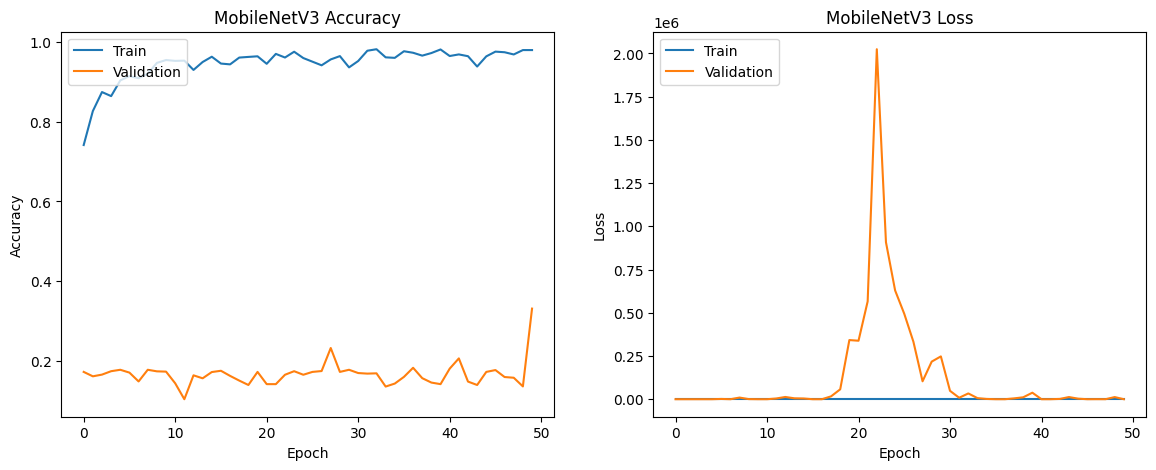

In [4]:
def plot_performance(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Plot performance for MobileNetV3
plot_performance(history_mobilenetv3, 'MobileNetV3')


In [5]:
# Compute mAP
y_true = test_generator.classes
y_pred_probs = mobilenetv3_model.predict(test_generator)

precision = dict()
recall = dict()
average_precision = dict()
n_classes = train_generator.num_classes

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

# Compute Mean Average Precision (mAP)
mean_average_precision = np.mean(list(average_precision.values()))
print(f'Mean Average Precision (mAP): {mean_average_precision}')


46/46 [==============================] - 29s 567ms/step
Mean Average Precision (mAP): 0.16905310912892937


46/46 [==============================] - 22s 477ms/step


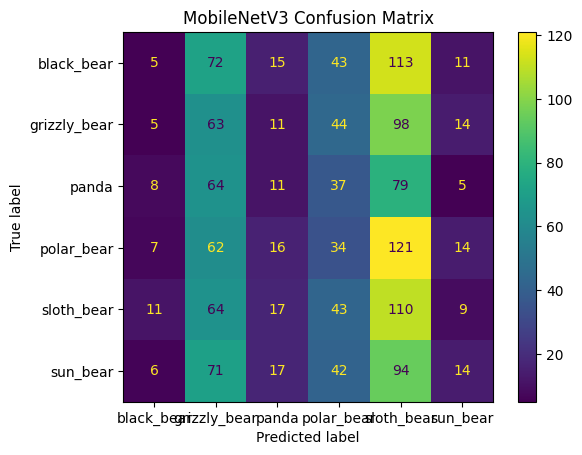

In [7]:
def plot_confusion_matrix(model, generator, model_name):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=generator.class_indices.keys()).plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot confusion matrix for MobileNetV3 on the test set
plot_confusion_matrix(mobilenetv3_model, test_generator, 'MobileNetV3')


In [8]:
train_loss, train_accuracy = mobilenetv3_model.evaluate(train_generator)
print(f'Loss: {train_loss}, Accuracy: {train_accuracy}')


265/265 [==============================] - 125s 472ms/step - loss: 2.8190 - accuracy: 0.3479
Loss: 2.818965196609497, Accuracy: 0.34785181283950806


In [7]:
val_loss, val_accuracy = mobilenetv3_model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

63/63 [==============================] - 80s 1s/step - loss: 2.1088 - accuracy: 0.6932
Validation loss: 2.108752489089966, Validation accuracy: 0.693153440952301


In [8]:
test_loss, test_accuracy = mobilenetv3_model.evaluate(test_generator)
print(f'loss: {test_loss}, acc: {test_accuracy}')


32/32 [==============================] - 40s 1s/step - loss: 1.9565 - accuracy: 0.7033
loss: 1.9565093517303467, acc: 0.7032967209815979
